In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import imp
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
import pytorch_models
import optuna
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram

db_name="sample_swap_free_final"

audio_frames=miru.audioFrames(loadCache=True)

audio_frames=pd.concat([miru.audioFrames(db_name="radar",loadCache=True),miru.audioFrames(db_name="sample_swap",loadCache=True)])
synth_noise_frames=miru.audioFrames(db_name="noise",loadCache=True)
def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])

def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="synth_noise"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))

audio_frames=audio_frames.loc[~audio_frames["label"].isin(["guitar","piano"])]        
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["synth_noise","guitar","piano","noise","voc","electronic_hits"])]


not_drum_frames=synth_noise_frames[0:2000]


./drum_dbs/dk_data ./drum_dbs/dk_data.dill
./drum_dbs/radar ./drum_dbs/radar.dill
./drum_dbs/sample_swap ./drum_dbs/sample_swap.dill
./drum_dbs/noise ./drum_dbs/noise.dill


In [3]:


#drum only classification
# audio_frames["label_num"].isin(not_drum_labels)
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))

#get weights for each group
# x=drum_frames.groupby(["label"]).agg("count")["path"]
y=audio_frames.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])


/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


label
clap                401
electronic_hits     235
hat                1275
kick               1334
noise               168
rim                  82
shake               116
snare              1035
tom                 167
voc                  73
Name: path, dtype: int64


In [4]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels,"path":rows["path"],"drum_type":rows["label"]}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
            self.audio_frame.loc[self.audio_frame["label"]=="synth_noise","label_num"]=1 #same as last thing prolly...
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvn",)

all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)

torch.Size([1, 30, 20]) tensor([1.0000, 0.7510, 0.6587, 0.6064, 0.5920, 0.5571, 0.5712, 0.5946, 0.6104,
        0.5860, 0.6349, 0.6037, 0.6322, 0.6379, 0.6251, 0.6660, 0.6572, 0.6709,
        0.6291, 0.6129, 0.6196, 0.6611, 0.6282, 0.6080, 0.6218, 0.6122, 0.5907,
        0.5847, 0.5520, 0.5503])


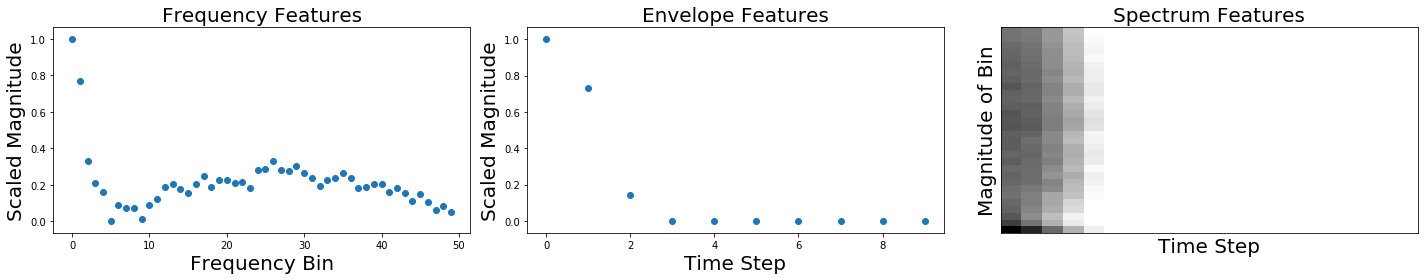

In [8]:
FREQ_BINS=30
TIME_STEPS=20
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20,amp_to_power=True):
        self.amp_to_power=amp_to_power
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
        if self.amp_to_power:
            s=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
# while True:
# sample = ds[np.random.randint(len(ds))]
#     print(sample["label"].item())
#     if sample["label"].item()==1:
#         break
freq_train = audioDataset(train,".",task="dvd")
f_train_loader= DataLoader(freq_train, batch_size=16, num_workers=1)
sample=iter(f_train_loader).next()
s={"signal":sample["signal"][0],"label":sample["label"][0],"path":sample["path"],"drum_type":sample["drum_type"]}
sample=s
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]

for i, tsfrm in enumerate(tfList):

    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ft=transformed_sample["feats"]
    if i==0:
        plt.title("Frequency Features",fontsize=20)
        plt.xlabel("Frequency Bin",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)
                   
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==1:
        plt.title("Envelope Features",fontsize=20)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)            
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==2:
        print(ft.shape,ft[0,:,0])
        sf=ft.detach().numpy()[0]
        ft=ft.detach().numpy()[0]
        plt.title("Spectrum Features",fontsize=20)
        librosa.display.specshow(sf,cmap='gray_r',)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Magnitude of Bin",fontsize=20)

#         plt.savefig("./plots/ff3.pdf",bbox_inches = "tight")
# plt.show()
# print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


In [6]:
def conv_output_shape(h_w, kernel_size=(1,5), stride=1, pad=(2,2), dilation=1):
    """
    Utility function for computing output of convolutions
    takes a tuple of (h,w) and returns a tuple of (h,w)
    """
    
    if type(h_w) is not tuple:
        h_w = (h_w, h_w)
    
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    
    if type(stride) is not tuple:
        stride = (stride, stride)
    
    if type(pad) is not tuple:
        pad = (pad, pad)
    
    h = (h_w[0] + (2 * pad[0]) - (dilation * (kernel_size[0] - 1)) - 1)// stride[0] + 1
    w = (h_w[1] + (2 * pad[1]) - (dilation * (kernel_size[1] - 1)) - 1)// stride[1] + 1
    
    print(h, w)
    return h, w
conv_output_shape(conv_output_shape((30,20)), kernel_size=(1,2), stride=1, pad=(0,0), dilation=0)

compression_dim=8
spec_dimension=FREQ_BINS*TIME_STEPS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])
all_frames = all_frames.reset_index(drop=True)
train=all_frames.sample(frac=0.50,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)


34 20
34 20


# SPEC ENCODER

In [7]:


class AE_Conv5x5(nn.Module):
    def __init__(self,input_shape,compression_dim,dropout_rate,num_channels=5,max_pool=2):
        super(AE_Conv5x5, self).__init__()
        self.H=input_shape[0]
        self.W=input_shape[1]
   
        self.dropout = nn.Dropout(dropout_rate)
        self.Encoder_Conv= nn.Sequential(
            nn.Conv2d(1, num_channels, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=max_pool, stride=max_pool))
        self.encoder_output_layer = nn.Linear(
            in_features=(self.H//max_pool * self.W//max_pool) * num_channels, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=self.W*self.H)
        
    def forward(self, features):
        features=features.reshape([-1,1,self.W,self.H])
        activation = self.Encoder_Conv(features)
        activation = self.dropout(torch.relu(activation))
        activation = activation.reshape(activation.size(0), -1)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    
class AE_Conv3x3(nn.Module):
    def __init__(self,input_shape,compression_dim,dropout_rate,num_channels=5,max_pool=1):
        super(AE_Conv3x3, self).__init__()
        self.H=input_shape[0]
        self.W=input_shape[1]

        self.dropout = nn.Dropout(dropout_rate)
        self.Encoder_Conv= nn.Sequential(
            nn.Conv2d(1, num_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=max_pool, stride=max_pool))
        self.encoder_output_layer = nn.Linear(
            in_features=(self.H//max_pool * self.W//max_pool) * num_channels, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=self.W*self.H)
        
    def forward(self, features):
        x3=3
        features=features.reshape([-1,1,self.W,self.H])
        activation = self.Encoder_Conv(features)
        activation = self.dropout(torch.relu(activation))
        activation = activation.reshape(activation.size(0), -1)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    
    

class AE_Conv1x3(nn.Module):
    def __init__(self,input_shape,compression_dim,dropout_rate,num_channels=5):
        super(AE_Conv1x3, self).__init__()
        self.H=input_shape[0]
        self.W=input_shape[1]

        self.dropout = nn.Dropout(dropout_rate)
        self.Encoder_Conv= nn.Sequential(
            nn.Conv2d(1, num_channels, kernel_size=[1,3], stride=1, padding=1),
            nn.ReLU(),
           )
  
        self.encoder_output_layer = nn.Linear(
            in_features=(36 * (self.W//2)) * num_channels, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=self.W*self.H)
        
    def forward(self, features):
        features=features.reshape([-1,1,self.W,self.H])
        activation = self.Encoder_Conv(features)
        activation = self.dropout(torch.relu(activation))
        activation = activation.reshape(activation.size(0), -1)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [41]:


def objective(trial):
    #optimized params
    learning_rate = 0.0011451089315356296
    dropout_rate = 0.5

  
    TIME_STEPS = 20
    hidden_layers = 2
    l2 = 3.2473701348597023e-06
    #hyper params
    latent_size = 32
    model_type=trial.suggest_categorical('Model Type', ['CNN5x5', 'CNN3x3','CNN1x3'])

    num_channels=trial.suggest_categorical('Num. Channels', [3, 5, 8])
#     max_pool=trial.suggest_categorical('Max Pool', [1, 2])
    max_pool=2
#     amp_to_power=trial.suggest_categorical('Amp to Power', ['True','False'])
    amp_to_power=True
    num_channels=3
    spec_dimension=FREQ_BINS*TIME_STEPS
  
    criterion=nn.MSELoss()
    model_type=="CNN1x3"
    if model_type=="CNN5x5":
        model = AE_Conv5x5(input_shape=[FREQ_BINS,TIME_STEPS],compression_dim=latent_size,dropout_rate=dropout_rate,
                           num_channels=num_channels,max_pool=max_pool,
                           ).to(device)
    
    if model_type=="CNN3x3":
        model = AE_Conv3x3(input_shape=[FREQ_BINS,TIME_STEPS],compression_dim=latent_size,dropout_rate=dropout_rate,
                           num_channels=num_channels,
                          ).to(device)
        
    if model_type=="CNN1x3":
        model = AE_Conv1x3(input_shape=[FREQ_BINS,TIME_STEPS],compression_dim=latent_size,dropout_rate=dropout_rate,
                           num_channels=num_channels,
                          ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=l2)
    print(model)
    #make dataloader 
    ptTune=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS,amp_to_power=amp_to_power,)])
    spec_data_train = audioDataset(train,".",task="dvn", transform=ptTune)
    spec_train_nosynth_loader= DataLoader(spec_data_train, batch_size=16,shuffle=True, num_workers=8)
    spec_data_test = audioDataset(test,".",task="dvn", transform=ptTune)
    spec_test_nosynth_loader= DataLoader(spec_data_test,batch_size=16,shuffle=True, num_workers=8)
    #train steps
    epochs=1
    for epoch in range(epochs):
        loss = 0
        for batch_features in spec_train_nosynth_loader:
            batch_features=batch_features["feats"]
            batch_features = batch_features.view(-1, spec_dimension).to(device)
            optimizer.zero_grad()
            outputs = model(batch_features)
            train_loss = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        loss = loss / len(spec_train_nosynth_loader)
        test_loss=0
        with torch.no_grad():
            for batch_features in spec_test_nosynth_loader:
                batch_features=batch_features["feats"]
                batch_features = batch_features.view(-1, spec_dimension).to(device)
                outputs = model(batch_features)
                temp_loss = criterion(outputs, batch_features)
                test_loss += temp_loss.item()
        test_loss = test_loss / len(spec_test_nosynth_loader) 
        trial.report(test_loss, epoch)   
        if epoch%10==0:
            if trial.should_prune():
                raise optuna.TrialPruned()
        print("epoch : {}/{}, loss = {:.6f}, test_loss = {:.6f}".format(epoch, epochs, loss,test_loss))
    return test_loss
study = optuna.create_study(study_name='Study_ALL',sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.MedianPruner(n_startup_trials = 5, n_warmup_steps= 10, interval_steps = 1),
                            storage='sqlite:///optuna_round2.db',load_if_exists=True)
study.optimize(objective, n_trials=100)


[I 2020-08-06 18:03:13,903] Using an existing study with name 'Study_ALL' instead of creating a new one.


AE_Conv1x3(
  (dropout): Dropout(p=0.5, inplace=False)
  (Encoder_Conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=[1, 3], stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (encoder_output_layer): Linear(in_features=1080, out_features=32, bias=True)
  (decoder_hidden_layer): Linear(in_features=32, out_features=256, bias=True)
  (decoder_output_layer): Linear(in_features=256, out_features=600, bias=True)
)


[W 2020-08-06 18:03:15,006] Setting status of trial#5 as TrialState.FAIL because of the following error: RuntimeError('size mismatch, m1: [16 x 1980], m2: [1080 x 32] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:290')
Traceback (most recent call last):
  File "/home/asalimi/miniconda3/lib/python3.7/site-packages/optuna/study.py", line 734, in _run_trial
    result = func(trial)
  File "<ipython-input-41-6f18fa7df8e9>", line 55, in objective
    outputs = model(batch_features)
  File "/home/asalimi/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 541, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-37-2b3f8f606847>", line 98, in forward
    code = self.encoder_output_layer(activation)
  File "/home/asalimi/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 541, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/asalimi/miniconda3/lib/python3.7/site-packages/torch/nn/modules/linear.py

RuntimeError: size mismatch, m1: [16 x 1980], m2: [1080 x 32] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:290

In [ ]:
from torchsummary import summary
from torchviz import make_dot, make_dot_from_trace
#optimized params
learning_rate = 0.0011451089315356296
dropout_rate = 0.5
latent_size = 8
FREQ_BINS = 30
TIME_STEPS = 20
hidden_layers = 2
l2 = 3.2473701348597023e-06

model = AE_Conv(input_shape=[FREQ_BINS,TIME_STEPS],compression_dim=latent_size,dropout_rate=dropout_rate,num_channels=5).to(device)
# model = AE_Linear_1H(input_shape=spec_dimension,compression_dim=latent_size,dropout_rate=dropout_rate).to(device)
# model = AE_Linear_2H(input_shape=FREQ_BINS*TIME_STEPS,compression_dim=latent_size,dropout_rate=dropout_rate).to(device)

dataiter=iter(spec_test_loader)
#does it work?
xy=dataiter.next()
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images=xy["feats"].detach()[0:1].reshape([FREQ_BINS*TIME_STEPS]).to(device)

summary(model,images.shape)

make_dot(model(images), params=dict(model.named_parameters()))

In [ ]:
study.trials_dataframe()

In [ ]:
import joblib
joblib.dump(study, 'study2.pkl')
study2 = joblib.load('study2.pkl')
print('Best trial until now:')
print(' Value: ', study2.best_trial.value)
print(' Params: ')
for key, value in study2.best_trial.params.items():
    print(f'    {key}: {value}')